In [1]:
%matplotlib inline
import os
import cv2
import csv
import glob
import time
import math
import random
import numpy as np
from numpy import array
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from datetime import timedelta

/Users/michellechen/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Configuration and Hyperparameters

In [2]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Top', 'Bottom', 'Shoes', 'Bag', 'Jewelry']
num_classes = len(classes)

# batch size
batch_size = 30

# validation split
validation_size = .2

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

# train_path = 'data/Items/Train/'
# test_path = 'data/Items/Test/'

# Creating new variables

In [3]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [4]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

# Creating a new Convolutional Layer

In [5]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

# Flattening a layer

In [6]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

# Creating a new Fully-Connected Layer

In [7]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# Placeholder variables

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [9]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [10]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [11]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


# Convolutional Layer 1, 2, 3

In [12]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [13]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 32) dtype=float32>

In [14]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [15]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 32) dtype=float32>

In [16]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [17]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

# Flatten Layer

In [18]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [19]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

In [20]:
num_features

16384

# Fully-Connected Layer 1, 2

In [21]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [22]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [23]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [24]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 5) dtype=float32>

# Predicted Class

In [25]:
y_pred = tf.nn.softmax(layer_fc2)

In [26]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

# Cost-function to be optimized

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [28]:
cost = tf.reduce_mean(cross_entropy)

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Performance Measures

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

In [32]:
# Create TensorFlow session
session = tf.Session()

# Initialize variables
session.run(tf.initialize_all_variables())

# Create saver to save and restore a trained model
saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Plot example errors

In [33]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

# Plot confusion matrix

In [34]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Showing the performance

In [35]:
def print_validation_accuracy(show_example_errors=False, show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.valid.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.valid.images[i:j, :].reshape(batch_size, img_size_flat)
    
        # Get the associated labels.
        labels = data.valid.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = np.array(data.valid.cls)
    cls_pred = np.array([classes[n] for n in cls_pred]) 

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

# Test on Sample Image

In [36]:
# Restore the trained model
saver.restore(session, "data/item_category_classifier.ckpt")

INFO:tensorflow:Restoring parameters from data/item_category_classifier.ckpt


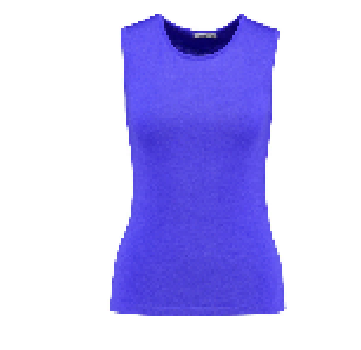

In [53]:
plt.axis('off')

test_cat = cv2.imread('data/Top.jpg')
test_cat = cv2.resize(test_cat, (img_size, img_size))
plt.imshow(test_cat.reshape(img_size, img_size, num_channels))

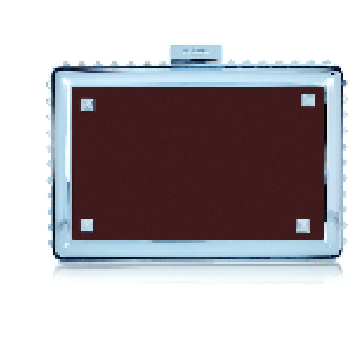

In [38]:
plt.axis('off')

test_dog = cv2.imread('data/Bag.jpg')
test_dog = cv2.resize(test_dog, (img_size, img_size))
plt.imshow(test_dog.reshape(img_size, img_size, num_channels))

In [39]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[0, 1, 2, 3, 4]]) 
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    probabilities = test_pred[0]
#     result = probabilities.eval(feed_dict=feed_dict_test, session=session)
    
    return classes[test_pred[0]], probabilities

print("Predicted class for test_cat: {}".format(sample_prediction(test_cat)))
print("Predicted class for test_dog: {}".format(sample_prediction(test_dog)))

Predicted class for test_cat: ('Top', 0)
Predicted class for test_dog: ('Bag', 3)


In [46]:
glob.glob('data/*')[0]

'data/Bag.jpg'

In [6]:
# Load outfit clustering LDA model
lda = gensim.models.LdaModel.load('data/lda_25topics_100iterations.model')

lda.print_topics(25)

[(0,
  u'0.016*"dolc" + 0.015*"gabbana" + 0.012*"christma" + 0.011*"oscar" + 0.010*"gown" + 0.010*"renta" + 0.009*"sequin" + 0.008*"giusepp" + 0.008*"zanotti" + 0.006*"parti"'),
 (1,
  u'0.047*"lauren" + 0.035*"spade" + 0.034*"ralph" + 0.029*"kate" + 0.022*"karl" + 0.020*"vinc" + 0.020*"lagerfeld" + 0.016*"camuto" + 0.016*"mankind" + 0.015*"rocha"'),
 (2,
  u'0.036*"michael" + 0.022*"kor" + 0.009*"simpson" + 0.008*"jessica" + 0.007*"widest" + 0.007*"deliveri" + 0.006*"skool" + 0.006*"pirat" + 0.006*"disney" + 0.006*"locket"'),
 (3,
  u'0.076*"watch" + 0.020*"stainless" + 0.019*"steel" + 0.018*"tori" + 0.017*"dial" + 0.017*"burch" + 0.015*"resist" + 0.013*"water" + 0.013*"quartz" + 0.009*"movement"'),
 (4,
  u'0.023*"blade" + 0.016*"iro" + 0.014*"loafer" + 0.013*"casadei" + 0.011*"bliss" + 0.011*"vian" + 0.011*"cluse" + 0.010*"mischief" + 0.009*"folli" + 0.009*"dakota"'),
 (5,
  u'0.019*"chanel" + 0.009*"david" + 0.008*"yurman" + 0.007*"quilt" + 0.006*"aso" + 0.006*"stuart" + 0.005*"wei

In [ ]:
# Generate pairs of candidate items in selected style

In [3]:
from shutil import copyfile

i = 11
while i <= 22:
    
    print "Style " + str(i)
    
    image_path = []

    # Read file by line, and store into a list
    with open("style/style" + str(i) + "_images.txt") as f:
        image_path = f.readlines()

    # Remove whitespace characters like \n at the end of each line
    image_path = [x.strip() for x in image_path]
    
    print len(image_path)
    
    for j in xrange(len(image_path)):
        
        # Copy item image files to style images
        copyfile(image_path[j], "style/style" + str(i) + "_images/" + image_path[j].split("-")[-1])
    
    print "\n"
    
    i = i + 1

Style 11
4859


Style 12
45683


Style 13
93


Style 14
13064


Style 15
682


Style 16
559


Style 17
374


Style 18
1333


Style 19
1168


Style 20
57


Style 21
1393


Style 22
89


